In [251]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os
import numpy as np

In [252]:
import pylab as plt
plt.rcParams.update({"axes.grid" : True})

In [253]:
from twpazer.freader import file2dic, dic2file

In [269]:
def dump(d, Ztarget, Z, l, L, C, w, Lk, islabel=True):
    labels = ['d' , 'Z0target', 'Z0' ,   'l'   , 'L'   , 'C'   , 'Lk',      'nsq', 'Lf', 'Cf']
    units  = ['nm', '[Ohm]'   , '[Ohm]', '[um]', '[pH]', '[fF]', '[pH/sq]', ''   , 'nH', '[fF]'] 
    
    nsq = l/w     # number of square per finger
    Lf  = Lk*nsq  # finger inductance to ground (Malnou's model)
    Cf  = C/2     # finger capacitance to ground (Malnou's model)
    
    formatter=''.join(['%-11s']*len(labels))
    
    restarget=[a*b for a,b in zip([d, Ztarget, Z, l ,L, C, Lk, nsq, Lf, Cf], 
                                  [1, 1, 1, 1, 1e12, 1e15, 1e12, 1, 1e9, 1e15])]
    

    if islabel:
        print (formatter%tuple(labels))
        print (formatter%tuple(units))
        print('-' * 110)
    print (formatter%tuple(["%.2f" % i for i in restarget]))
        
    return

In [255]:
Z0fun = lambda L, C : np.sqrt(L/C)

In [256]:
def create_path(Lk,e, d, basepath):
        
    filepath = os.path.join(basepath,    
                            'Lk{Lk}_eps{e:.1f}_d{d}'.format(Lk=Lk, e=e, d=d), 
                            'savepath')
        
    return os.path.join(filepath, [d for d in os.listdir(filepath) if 'reduced' in d][0])

In [257]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

In [258]:
basepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/v3/ellfree_v_d/analysis/simdata'
savepath = '/home/giachero/gsbox/kids_rd/DARTWARS/sonnet-sim/IMS-NIST/v3/ellfree_v_d/analysis/savedata'

os.makedirs(savepath) if not os.path.exists(savepath) else None

In [259]:
ds  = [100, 200, 300, 400]
(eps, Lk) = (9.1, 30)

In [260]:
from matplotlib import cm, colors
cmap   = plt.cm.turbo_r
cols   = get_colors(ds, cmap, 
                    vmin=np.min(ds), vmax=np.max(ds))
cols   = dict(zip(reversed(ds), cols))

<IPython.core.display.Javascript object>


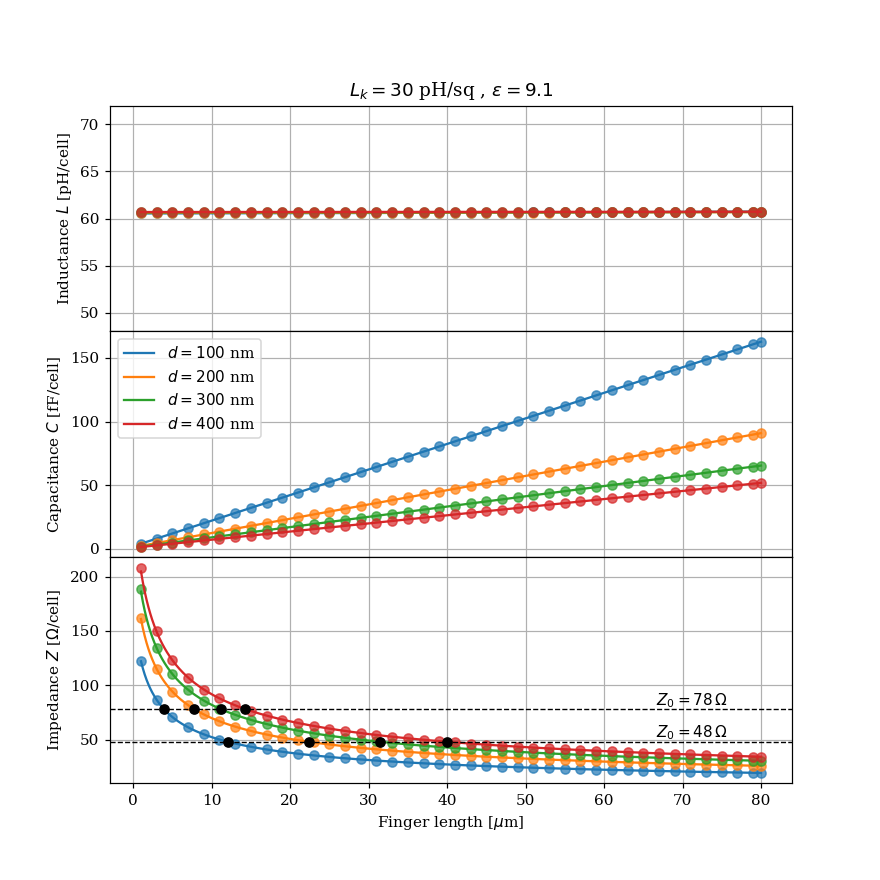

In [261]:
resdata=dict()

resdata.setdefault('data',{})

fig, ax = plt.subplots(3,1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for d in ds:
    
    filename = create_path(Lk, eps, d, basepath)    
    resdata['data'].setdefault(d, {})
    resdata['data'][d] = file2dic(filename, writer='h5').read()
    
    resdata['data'][d].update({'Z'   : Z0fun(resdata['data'][d]['L'],    resdata['data'][d]['C']),                                                                                                   
                               'Zfit': Z0fun(resdata['data'][d]['Lfit'], resdata['data'][d]['Cfit'])})
    
    ax[0].plot(resdata['data'][d]['l'], resdata['data'][d]['L']*1e12, marker = 'o', ls='none',     
                 alpha=0.7)
    ax[0].plot(resdata['data'][d]['lfit'], resdata['data'][d]['Lfit']*1e12, marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color())
    ax[0].set_ylim([48, 72])
    
    
    ax[1].plot(resdata['data'][d]['l'], resdata['data'][d]['C']*1e15, marker = 'o', ls='none',     
                 alpha=0.7)
    ax[1].plot(resdata['data'][d]['lfit'], resdata['data'][d]['Cfit']*1e15, marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color(), label='$d={d}$ nm'.format(d=d))
    
    
    ax[2].plot(resdata['data'][d]['l'], resdata['data'][d]['Z'], marker = 'o', ls='none',     
                 alpha=0.7)
    ax[2].plot(resdata['data'][d]['lfit'], resdata['data'][d]['Zfit'], marker = 'none', ls='-',                   
                 color=ax[0].lines[-1].get_color())
    
    


ylabels=['Inductance $L$ [pH/cell]', 'Capacitance $C$ [fF/cell]', 'Impedance $Z$ [$\\Omega$/cell]']
    
for i in [0,1,2]:    
    
    if i == 0: 
        ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
    
    if i == 1: 
        ax[i].legend(loc='upper left')
        
    if i == 2:
        ax[i].set_xlabel('Finger length [$\\mu$m]')
    
    if i != 2:
        ax[i].tick_params('x', labelbottom=False)
        
    ax[i].set_ylabel(ylabels[i])
   



In [262]:
Zarget = [78, 48]
for Z0target in Zarget:
    ax[2].axhline(y=Z0target, color='black', lw=0.9, ls='--')    
    xtext=ax[2].get_xlim()[1]-0.20*(ax[2].get_xlim()[1]-ax[2].get_xlim()[0])    
    ax[2].text(xtext, Z0target+4, r'$Z_0 = {Z}\,\Omega$'.format(Z=Z0target))

In [263]:
resdata.setdefault('lbest',{})
Zarget = [78, 48]
resdata['lbest'].update({Z: {'l': list(), 'L': list(), 'C': list(), 'Z': list(), 'd': list(),}  for Z in Zarget })   

for d in resdata['data']: 
    for Z in Zarget:
        resdata['lbest'][Z]['d'].append(d)
        idx=np.argmin(np.abs(Z-resdata['data'][d]['Zfit']))
        resdata['lbest'][Z]['Z'].append(resdata['data'][d]['Zfit'][idx])
        resdata['lbest'][Z]['C'].append(resdata['data'][d]['Cfit'][idx])
        resdata['lbest'][Z]['L'].append(resdata['data'][d]['Lfit'][idx])
        resdata['lbest'][Z]['l'].append(resdata['data'][d]['lfit'][idx])

for Z in Zarget:
    for x in ['d', 'Z', 'C', 'L', 'l']:
        resdata['lbest'][Z][x]=np.array(resdata['lbest'][Z][x])
    

In [264]:
for Z in Zarget:
    ax[2].plot(resdata['lbest'][Z]['l'],             
               resdata['lbest'][Z]['Z'],                                 
               marker='o', ls='none', color='k', zorder=100)
    
for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(savepath,'global_trend_ell_vs_d'+e),
                      bbox_inches='tight', transparent=True)


<IPython.core.display.Javascript object>


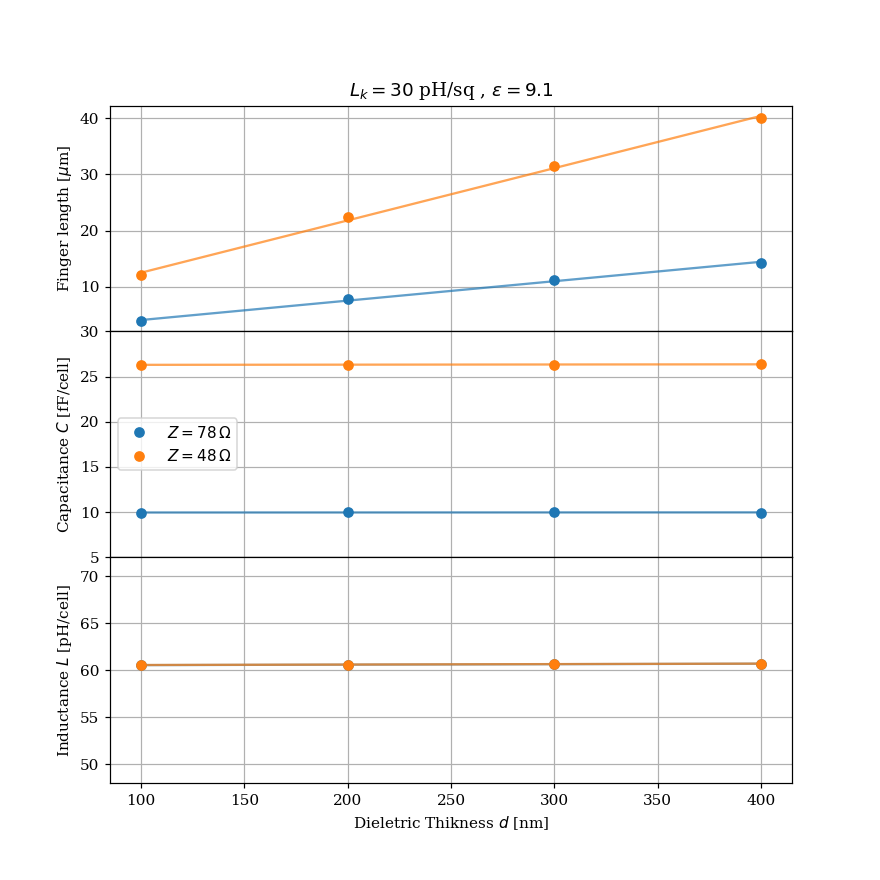

 
0.03448 x + 0.6837
 
0.09284 x + 3.254


In [278]:
fig, ax = plt.subplots(3,1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)

for Z in resdata['lbest']:
    ax[0].plot(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['l'], marker='o', ls='none',                                       
               label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
    p = np.poly1d(np.polyfit(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['l'], 1))
    ax[0].plot(resdata['lbest'][Z]['d'], p(resdata['lbest'][Z]['d']),                               
               color=ax[0].lines[-1].get_color(), alpha=0.7)
        
    print(p)
    resdata['lbest'][Z]['pl']=[p.coef[0], p.coef[1]]
     
    
    ax[1].plot(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['C']*1e15, marker='o', ls='none',                              
             label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
    p = np.poly1d(np.polyfit(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['C'], 1))
    ax[1].plot(resdata['lbest'][Z]['d'], p(resdata['lbest'][Z]['d'])*1e15,                              
               color=ax[1].lines[-1].get_color(), alpha=0.7)
        
    ax[1].set_ylim([5, 30])
    
    resdata['lbest'][Z]['pC']=[p.coef[0], p.coef[1]]
    
    
    ax[2].plot(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['L']*1e12, marker='o', ls='none',                                           
               label='$Z={Z}\,\\Omega$'.format(Z=Z))
    
    p = np.poly1d(np.polyfit(resdata['lbest'][Z]['d'], resdata['lbest'][Z]['L'], 1))
    ax[2].plot(resdata['lbest'][Z]['d'], p(resdata['lbest'][Z]['d'])*1e12,                      
               color=ax[2].lines[-1].get_color(), alpha=0.7)
    
    ax[2].set_ylim([48, 72])
    
    resdata['lbest'][Z]['pL']=[p.coef[0], p.coef[1]]
       
    

ylabels=['Finger length [$\\mu$m]', 'Capacitance $C$ [fF/cell]', 'Inductance $L$ [pH/cell]']
    
for i in [0,1,2]:    
    
    if i == 0: 
        ax[i].set_title('$L_k = {Lk}$ pH/sq , $\\varepsilon = {eps}$'.format(Lk=Lk, eps=eps))
    
    if i == 1: 
        ax[i].legend(loc='center left')
    
    if  i == 2:
        ax[i].set_xlabel('Dieletric Thikness $d$ [nm]')
    
        
    if i != 2:
        ax[i].tick_params('x', labelbottom=False)
        
    ax[i].set_ylabel(ylabels[i])
    
    #print(p)
    #print(Z, p.coef[0], p.coef[1])
    
#plt.ylabel('Finger length $\ell$ [$\\mu$m]')
#plt.xlabel('Dieletric Thickness $d$ [nm]')
#plt.legend(loc="upper left")


for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(savepath,'global_trend_Z_and_ell_vs_d'+e),
                      bbox_inches='tight', transparent=True)

In [270]:
Zarget = [78, 48]
w  = 1    # finger width

islabel=True
for d in resdata['data']:    
    for Z in Zarget:
        idx=np.argmin(np.abs(Z-resdata['data'][d]['Zfit']))
        dump(d, Z,              
            resdata['data'][d]['Zfit'][idx], 
            resdata['data'][d]['lfit'][idx],              
            resdata['data'][d]['Lfit'][idx],             
            resdata['data'][d]['Cfit'][idx],              
            w, Lk*1e-12, islabel)
        islabel=False

d          Z0target   Z0         l          L          C          Lk         nsq        Lf         Cf         
nm         [Ohm]      [Ohm]      [um]       [pH]       [fF]       [pH/sq]               nH         [fF]       
--------------------------------------------------------------------------------------------------------------
100.00     78.00      78.02      3.93       60.54      9.95       30.00      3.93       0.12       4.97       
100.00     48.00      47.97      12.07      60.56      26.32      30.00      12.07      0.36       13.16      
200.00     78.00      77.93      7.80       60.60      9.98       30.00      7.80       0.23       4.99       
200.00     48.00      47.99      22.35      60.61      26.31      30.00      22.35      0.67       13.16      
300.00     78.00      77.89      11.20      60.65      10.00      30.00      11.20      0.34       5.00       
300.00     48.00      47.99      31.45      60.66      26.34      30.00      31.45      0.94       13.17      
4

In [279]:
for Z in Zarget:    
    print(Z, resdata['lbest'][Z]['pl'][0], resdata['lbest'][Z]['pl'][1])  
    

78 0.034478478478478465 0.6836836836836836
48 0.09283883883883884 3.25375375375374
